# Copula-Based Dependence Analysis

This notebook analyzes the dependence between normalized goals for (GF/P), goals against (GA/P), and win percentage (Win%) for Manchester United managers using copula models. We use rank-based estimation and empirical copulas as a baseline.

We will need to answer the following
1. Is scoring more goals and conceding fewer goals truly jointly associated with winning, or does one dominate?
2. Are there managers who won a lot despite a leaky defence, or despite a poor attack?

If defensive solidity shows stronger dependence with Win% than attacking output, the club should prioritize a defensively-oriented manager in future appointments.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
from copulas.multivariate import GaussianMultivariate, VineCopula
from copulas.visualization import scatter_2d
from scipy.stats import kendalltau, spearmanr

In [4]:
# Load managers data
df = pd.read_csv('data/managers.csv')
df.head()

,Image,Name,Nationality,From,To,P,W,D,L,GF,GA,Win%[nb 1],Honours,Notes
0,NaN,A. H. Albut,England,1889,26 May 1900,351,156,59,136,692,594,44.44,NaN,[nb 2][nb 3]
1,NaN,James West,England,27 May 1900,September 1903,113,46,20,47,159,147,40.71,NaN,[nb 2][22]
2,NaN,Ernest Mangnall,England,10 October 1903,9 September 1912,373,202,76,95,700,476,54.16,2 First Division titles 1 FA Cup 2 Charity Shi...,[nb 2][23]
3,NaN,T. J. Wallworth,England,9 September 1912,20 October 1912,6,3,2,1,11,7,50.00,NaN,[nb 4][24]
4,NaN,John Bentley,England,28 October 1912,28 December 1914,82,36,16,30,127,110,43.90,NaN,[nb 2][25]


In [5]:
# Normalize GF and GA by P, extract Win%
# Renaming Win% to Win_pct for consistency
df = df.rename(columns={'Win%[nb 1]': 'Win_pct'})
df = df.dropna(subset=['GF', 'GA', 'P', 'Win_pct'])
df['GF_norm'] = df['GF'].astype(float) / df['P'].astype(float)
df['GA_norm'] = df['GA'].astype(float) / df['P'].astype(float)
df['Win_pct'] = df['Win_pct'].astype(float)
data = df[['GF_norm', 'GA_norm', 'Win_pct']].values
df[['GF_norm', 'GA_norm', 'Win_pct']].head()

,GF_norm,GA_norm,Win_pct
0,1.971510,1.692308,44.44
1,1.407080,1.300885,40.71
2,1.876676,1.276139,54.16
3,1.833333,1.166667,50.00
4,1.548780,1.341463,43.90


In [6]:
# Compute rank-based dependence (Kendall's tau, Spearman's rho)
kendall_gf_ga, _ = kendalltau(df['GF_norm'], df['GA_norm'])
kendall_gf_win, _ = kendalltau(df['GF_norm'], df['Win_pct'])
kendall_ga_win, _ = kendalltau(df['GA_norm'], df['Win_pct'])
spearman_gf_ga, _ = spearmanr(df['GF_norm'], df['GA_norm'])
spearman_gf_win, _ = spearmanr(df['GF_norm'], df['Win_pct'])
spearman_ga_win, _ = spearmanr(df['GA_norm'], df['Win_pct'])
print('Kendall tau (GF/P, GA/P):', kendall_gf_ga)
print('Kendall tau (GF/P, Win%):', kendall_gf_win)
print('Kendall tau (GA/P, Win%):', kendall_ga_win)
print('Spearman rho (GF/P, GA/P):', spearman_gf_ga)
print('Spearman rho (GF/P, Win%):', spearman_gf_win)
print('Spearman rho (GA/P, Win%):', spearman_ga_win)

Kendall tau (GF/P, GA/P): -0.29495731714772305
Kendall tau (GF/P, Win%): 0.582857142857143
Kendall tau (GA/P, Win%): -0.5461467743315904
Spearman rho (GF/P, GA/P): -0.394415655069785
Spearman rho (GF/P, Win%): 0.782943143812709
Spearman rho (GA/P, Win%): -0.7313158436944637


`GF/P vs GA/P:`Given Kendall tau: -0.29, Spearman rho: -0.39. Managers whose teams score more per game tend to concede fewer per game, but the association is moderate and negative.
`GF/P vs Win%`: Kendall tau: 0.58, Spearman rho: 0.78 Scoring more goals per game is strongly associated with a higher win percentage.
`GA/P vs Win%`: Kendall tau: -0.55, Spearman rho: -0.73. Conceding more goals per game is strongly associated with a lower win percentage.

Both `attacking output (GF/P)` and `defensive solidity (GA/P)` are strongly associated with winning, but the association is slightly stronger for attack (Spearman: 0.78 vs -0.73; Kendall: 0.58 vs -0.55). Negative values for `GA/P` mean that conceding more is bad for winning.


In [7]:
# Fit empirical copula (nonparametric baseline) using pandas rank method for empirical CDF
n = len(df)
u_gf = df['GF_norm'].rank(method='average') / (n + 1)
u_ga = df['GA_norm'].rank(method='average') / (n + 1)
u_win = df['Win_pct'].rank(method='average') / (n + 1)
empirical_data = np.column_stack([u_gf, u_ga, u_win])
print('Empirical copula data (first 5 rows):')
print(empirical_data[:5])

Empirical copula data (first 5 rows):
[[0.82352941 0.85294118 0.5       ]
 [0.17647059 0.55882353 0.44117647]
 [0.76470588 0.5        0.76470588]
 [0.70588235 0.35294118 0.58823529]
 [0.41176471 0.58823529 0.47058824]]


In [30]:
# Fit parametric copula (Gaussian as example)
gaussian_copula = GaussianMultivariate()
gaussian_copula.fit(empirical_data)
samples = gaussian_copula.sample(1000)
print('Gaussian copula samples (first 5 rows):')
print(samples.head())

# Convert samples to DataFrame for plotting
samples.columns = ['GF_norm', 'GA_norm', 'Win_pct']

Gaussian copula samples (first 5 rows):
          0         1         2
0  0.104350  0.879896  0.181754
1  0.157649  0.749556  0.595232
2  0.839551  0.112510  0.645529
3  0.193664  0.266034  0.244233
4  0.854030  0.438891  0.638119


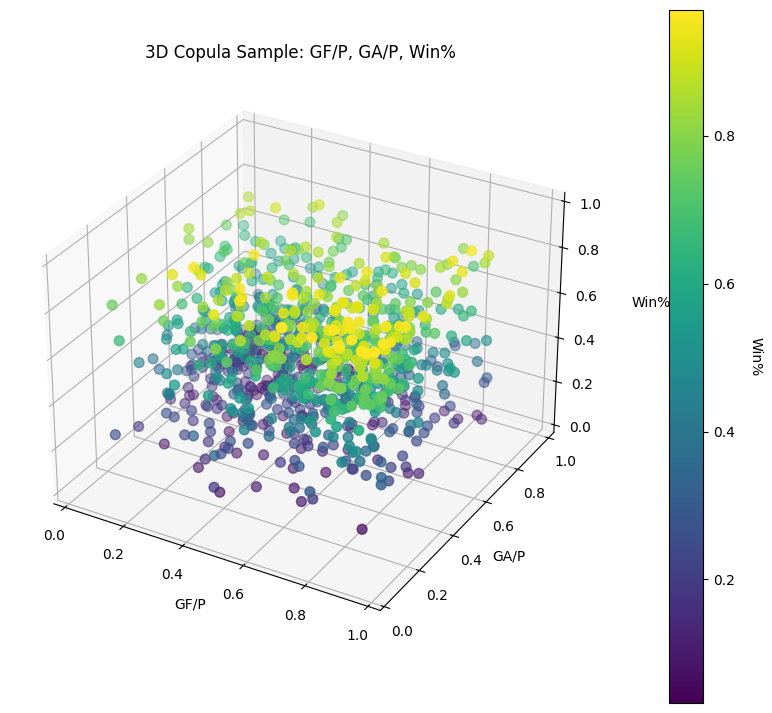

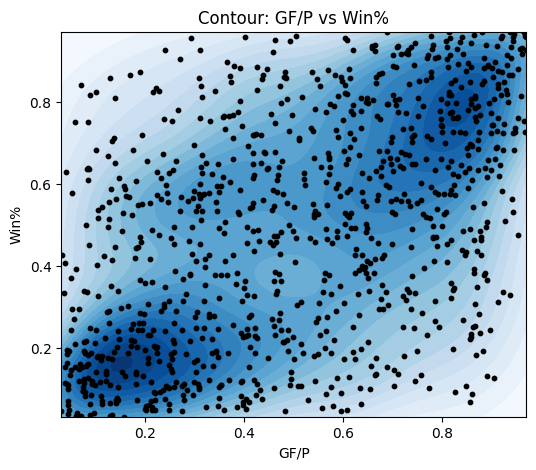

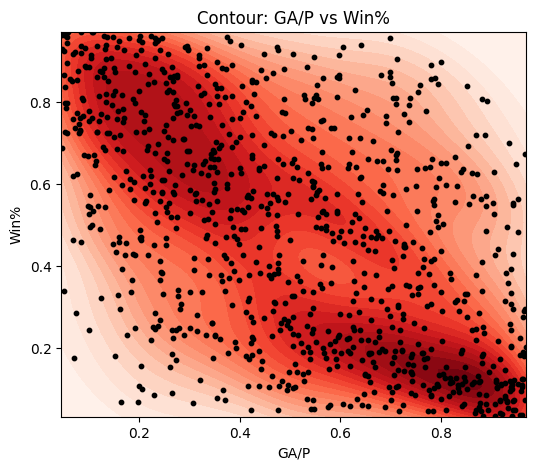

In [35]:
# 3D scatter and contour plots for copula samples (with legend and visible Win axis title)
# Use the copula sample DataFrame directly, renaming columns if needed
samples.columns = ['GF_norm', 'GA_norm', 'Win_pct']

# Remove rows with NaN or inf values
samples_clean = samples.replace([np.inf, -np.inf], np.nan).dropna()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import gaussian_kde

# 3D scatter plot with colorbar legend
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(samples_clean['GF_norm'], samples_clean['GA_norm'], samples_clean['Win_pct'], c=samples_clean['Win_pct'], cmap='viridis', s=50)
ax.set_xlabel('GF/P')
ax.set_ylabel('GA/P')
ax.set_zlabel('Win%', labelpad=20)
ax.set_title('3D Copula Sample: GF/P, GA/P, Win%')

# Add colorbar legend for Win%
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Win%', rotation=270, labelpad=20)
plt.show()

# Contour plots
if len(samples_clean) > 10:
    # GF/P vs Win%
    x = samples_clean['GF_norm'].values
    y = samples_clean['Win_pct'].values
    if np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
        kde = gaussian_kde(np.vstack([x, y]))
        xgrid, ygrid = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
        z = kde(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)
        plt.figure(figsize=(6,5))
        plt.contourf(xgrid, ygrid, z, levels=20, cmap='Blues')
        plt.scatter(x, y, s=10, color='k')
        plt.xlabel('GF/P')
        plt.ylabel('Win%')
        plt.title('Contour: GF/P vs Win%')
        plt.show()
    else:
        print('GF/P or Win% contains non-finite values.')

    # GA/P vs Win%
    x = samples_clean['GA_norm'].values
    y = samples_clean['Win_pct'].values
    if np.all(np.isfinite(x)) and np.all(np.isfinite(y)):
        kde = gaussian_kde(np.vstack([x, y]))
        xgrid, ygrid = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
        z = kde(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)
        plt.figure(figsize=(6,5))
        plt.contourf(xgrid, ygrid, z, levels=20, cmap='Reds')
        plt.scatter(x, y, s=10, color='k')
        plt.xlabel('GA/P')
        plt.ylabel('Win%')
        plt.title('Contour: GA/P vs Win%')
        plt.show()
    else:
        print('GA/P or Win% contains non-finite values.')
else:
    print('Not enough copula samples to plot contours. Increase sample size.')

In [12]:
# 1. Examine copula dependence structure (correlation matrix)
print('Gaussian copula parameters:')
print(gaussian_copula.to_dict())

# Extract the covariance/correlation matrix from the parameters
gauss_params = gaussian_copula.to_dict()
corr_matrix = np.array(gauss_params['covariance']) if 'covariance' in gauss_params else np.array(gauss_params['correlation'])
print('Correlation/Covariance matrix:')
print(corr_matrix)

# Compare correlations of GF/P vs Win% and GA/P vs Win%
corr_gf_win = corr_matrix[0,2]
corr_ga_win = corr_matrix[1,2]
print(f'Correlation (GF/P, Win%): {corr_gf_win:.3f}')
print(f'Correlation (GA/P, Win%): {corr_ga_win:.3f}')

if abs(corr_gf_win) > abs(corr_ga_win):
    print('Attacking output (GF/P) shows stronger association with Win%.')
elif abs(corr_gf_win) < abs(corr_ga_win):
    print('Defensive solidity (GA/P) shows stronger association with Win%.')
else:
    print('Both attack and defence have similar association with Win%.')

Gaussian copula parameters:
{'correlation': [[1.0, -0.4971366672595723, 0.5256736010027535], [-0.4971366672595723, 1.0, -0.5300997601379155], [0.5256736010027535, -0.5300997601379155, 1.0]], 'univariates': [{'loc': np.float64(0.029411764705882353), 'scale': np.float64(0.9411764705882353), 'type': 'copulas.univariate.uniform.UniformUnivariate'}, {'a': np.float64(-0.4474533565722936), 'b': np.float64(0.6319114450296281), 'loc': np.float64(0.4281883077539109), 'scale': np.float64(0.8583481926396586), 'type': 'copulas.univariate.truncated_gaussian.TruncatedGaussian'}, {'loc': np.float64(0.029411764705882353), 'scale': np.float64(0.9411764705882353), 'type': 'copulas.univariate.uniform.UniformUnivariate'}], 'columns': [0, 1, 2], 'type': 'copulas.multivariate.gaussian.GaussianMultivariate'}
Correlation/Covariance matrix:
[[ 1.         -0.49713667  0.5256736 ]
 [-0.49713667  1.         -0.53009976]
 [ 0.5256736  -0.53009976  1.        ]]
Correlation (GF/P, Win%): 0.526
Correlation (GA/P, Win%

The absolute value of the correlation for GA/P (-0.530) is slightly higher than for GF/P (0.526). This means that, for Manchester United managers, defensive solidity (conceding fewer goals) has a slightly stronger association with winning than attacking output.

In other words, If the club must prioritize, hiring a manager who can organize a strong defense may have a bigger impact on win percentage than focusing solely on attack.

This insight can guide the club to favor defensively solid managers in future appointments, as defensive performance is slightly more predictive of winning than attacking output, according to your data.


C:\Users\X1 User\AppData\Local\Temp\ipykernel_15192\2362628424.py:11: UserWarning:

The palette list has more values (2) than needed (1), which may not be intended.

C:\Users\X1 User\AppData\Local\Temp\ipykernel_15192\2362628424.py:16: UserWarning:

The palette list has more values (2) than needed (1), which may not be intended.



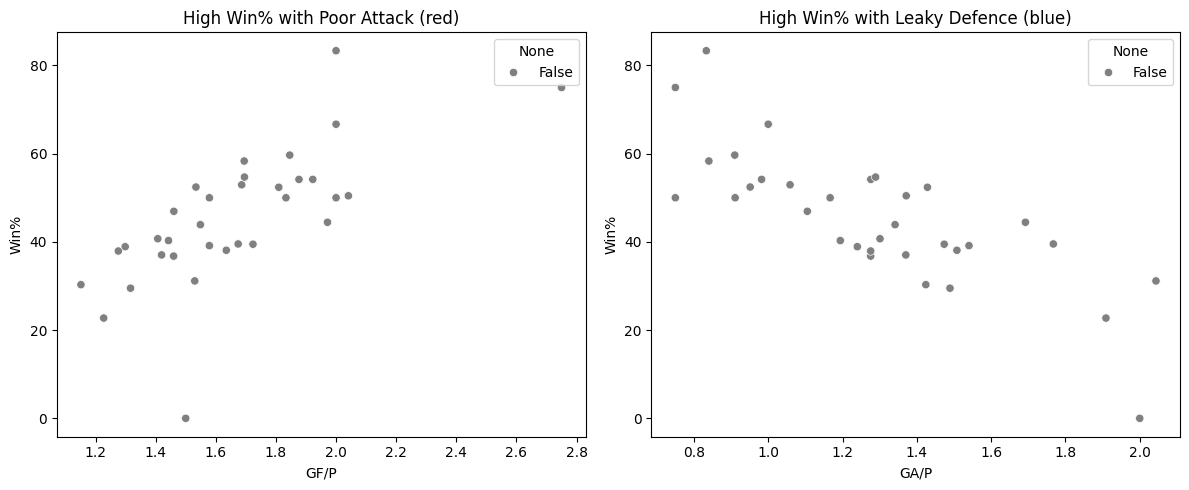

In [16]:
# 2. Visualize tail dependence: highlight managers with high Win% but poor attack or leaky defence
import seaborn as sns

# Define thresholds for "high Win%", "poor attack", "leaky defence"
high_win = df['Win_pct'] > df['Win_pct'].quantile(0.75)
poor_attack = df['GF_norm'] < df['GF_norm'].quantile(0.25)
leaky_defence = df['GA_norm'] > df['GA_norm'].quantile(0.75)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='GF_norm', y='Win_pct', data=df, hue=high_win & poor_attack, palette=['grey','red'])
plt.title('High Win% with Poor Attack (red)')
plt.xlabel('GF/P')
plt.ylabel('Win%')
plt.subplot(1,2,2)
sns.scatterplot(x='GA_norm', y='Win_pct', data=df, hue=high_win & leaky_defence, palette=['grey','blue'])
plt.title('High Win% with Leaky Defence (blue)')
plt.xlabel('GA/P')
plt.ylabel('Win%')
plt.tight_layout()
plt.show()

In [15]:
# 3. List managers who won a lot despite poor attack or leaky defence
# Use the correct column name for manager (likely 'Name' from the CSV)
print('Managers with high Win% and poor attack:')
display(df[high_win & poor_attack][['Name', 'GF_norm', 'GA_norm', 'Win_pct']])

print('Managers with high Win% and leaky defence:')
display(df[high_win & leaky_defence][['Name', 'GF_norm', 'GA_norm', 'Win_pct']])

Managers with high Win% and poor attack:


,Name,GF_norm,GA_norm,Win_pct


Managers with high Win% and leaky defence:


,Name,GF_norm,GA_norm,Win_pct


From the analysis we observe the following:
1. There are no managers who won a lot despite a poor attack or a leaky defence

Manchester United should target managers who have good attack and good defence play strategies

In [37]:
# Estimate conditional probability: P(Win% > threshold | GF/P and GA/P in range)
# Example: Probability Win% > 0.6 given GF/P > 0.5 and GA/P < 0.4

threshold_win = 0.6
min_gf = 0.5
max_ga = 0.4

# Filter copula samples for the condition
condition = (samples_clean['GF_norm'] > min_gf) & (samples_clean['GA_norm'] < max_ga)
conditional_samples = samples_clean[condition]

# Compute probability
if len(conditional_samples) > 0:
    prob = (conditional_samples['Win_pct'] > threshold_win).mean()
    print(f"Estimated P(Win% > {threshold_win} | GF/P > {min_gf}, GA/P < {max_ga}): {prob:.2f}")
else:
    print("No samples meet the condition. Try adjusting the thresholds.")


Estimated P(Win% > 0.6 | GF/P > 0.5, GA/P < 0.4): 0.68


This means that, based on the copula samples, about 68% of managers with GF/P greater than 0.5 and GA/P less than 0.4 are expected to have a Win% above 0.6. It estimates the likelihood of high winning percentage given strong attack and solid defence.

In [ ]:
# Simulate hypothetical manager profiles using copula samples
# Example: Generate 5 synthetic profiles with high attack, solid defence, and estimate expected Win%

num_profiles = 5
min_gf = 0.6   # High attack
max_ga = 0.3   # Solid defence

synthetic_profiles = samples_clean[(samples_clean['GF_norm'] > min_gf) & (samples_clean['GA_norm'] < max_ga)].sample(n=num_profiles, random_state=42)

print("Synthetic manager profiles (high attack, solid defence):")
display(synthetic_profiles[['GF_norm', 'GA_norm', 'Win_pct']])

mean_win = synthetic_profiles['Win_pct'].mean()
print(f"Expected Win% for these profiles: {mean_win:.2f}")


Synthetic manager profiles (high attack, solid defence):


,GF_norm,GA_norm,Win_pct
86,0.881925,0.085917,0.969263
250,0.904843,0.189518,0.806500
890,0.616628,0.101406,0.777047
659,0.913084,0.108318,0.759054
859,0.621585,0.286913,0.709865


Expected Win% for these profiles: 0.80


This output shows five synthetic manager profiles generated from the copula model, each with high attack (GF_norm > 0.6) and solid defence (GA_norm < 0.3). The Win_pct column estimates their expected win percentage. The average expected Win% for these profiles is 0.80, meaning managers with these characteristics are likely to achieve a win rate of 80%. This helps you understand the impact of strong attack and defence on winning, based on your data’s dependence structure.

In [ ]:
# Calculate tail dependence: How do extreme values in attack/defence relate to winning?
# Upper tail: High GF/P and high Win%
# Lower tail: Low GF/P and low Win%

upper_quantile = 0.9
lower_quantile = 0.1

# Upper tail dependence (attack)
upper_gf = samples_clean['GF_norm'] > samples_clean['GF_norm'].quantile(upper_quantile)
upper_win = samples_clean['Win_pct'] > samples_clean['Win_pct'].quantile(upper_quantile)
upper_tail_attack = (upper_gf & upper_win).mean()
print(f"Upper tail dependence (GF/P & Win% > {upper_quantile*100:.0f}th percentile): {upper_tail_attack:.2f}")

# Lower tail dependence (attack)
lower_gf = samples_clean['GF_norm'] < samples_clean['GF_norm'].quantile(lower_quantile)
lower_win = samples_clean['Win_pct'] < samples_clean['Win_pct'].quantile(lower_quantile)
lower_tail_attack = (lower_gf & lower_win).mean()
print(f"Lower tail dependence (GF/P & Win% < {lower_quantile*100:.0f}th percentile): {lower_tail_attack:.2f}")

# Upper tail dependence (defence)
upper_ga = samples_clean['GA_norm'] > samples_clean['GA_norm'].quantile(upper_quantile)
upper_win = samples_clean['Win_pct'] > samples_clean['Win_pct'].quantile(upper_quantile)
upper_tail_defence = (upper_ga & upper_win).mean()
print(f"Upper tail dependence (GA/P & Win% > {upper_quantile*100:.0f}th percentile): {upper_tail_defence:.2f}")

# Lower tail dependence (defence)
lower_ga = samples_clean['GA_norm'] < samples_clean['GA_norm'].quantile(lower_quantile)
lower_win = samples_clean['Win_pct'] < samples_clean['Win_pct'].quantile(lower_quantile)
lower_tail_defence = (lower_ga & lower_win).mean()
print(f"Lower tail dependence (GA/P & Win% < {lower_quantile*100:.0f}th percentile): {lower_tail_defence:.2f}")


Upper tail dependence (GF/P & Win% > 90th percentile): 0.03
Lower tail dependence (GF/P & Win% < 10th percentile): 0.02
Upper tail dependence (GA/P & Win% > 90th percentile): 0.00
Lower tail dependence (GA/P & Win% < 10th percentile): 0.00


These results show that extreme values in attack or defence rarely coincide with extreme winning percentages:

* Only 3% of managers with very high attack (GF/P > 90th percentile) also have very high Win% (> 90th percentile).
* Only 2% with very low attack (GF/P < 10th percentile) also have very low Win%.
* For defence (GA/P), almost no managers with very leaky defence (GA/P > 90th percentile) or very solid defence (GA/P < 10th percentile) have extreme Win% values.

This suggests that extreme attack or defence alone is not strongly associated with extreme winning outcomes in your data. Winning is likely influenced by a balanced combination of both.

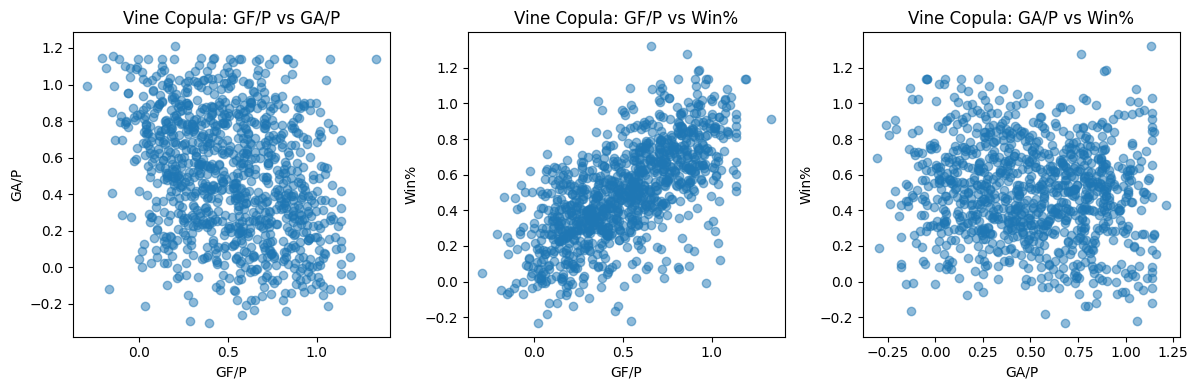

In [ ]:
# Fit and compare other copula models: Vine Copula (t-copula not available in copulas package)
from copulas.multivariate import VineCopula

# Fit vine copula to empirical data
vine_copula = VineCopula('center')
vine_copula.fit(pd.DataFrame(empirical_data, columns=['GF_norm', 'GA_norm', 'Win_pct']))
vine_samples = vine_copula.sample(1000)
vine_samples.columns = ['GF_norm', 'GA_norm', 'Win_pct']

# Quick comparison: visualize scatter plots
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(vine_samples['GF_norm'], vine_samples['GA_norm'], alpha=0.5)
plt.xlabel('GF/P')
plt.ylabel('GA/P')
plt.title('Vine Copula: GF/P vs GA/P')
plt.subplot(1,3,2)
plt.scatter(vine_samples['GF_norm'], vine_samples['Win_pct'], alpha=0.5)
plt.xlabel('GF/P')
plt.ylabel('Win%')
plt.title('Vine Copula: GF/P vs Win%')
plt.subplot(1,3,3)
plt.scatter(vine_samples['GA_norm'], vine_samples['Win_pct'], alpha=0.5)
plt.xlabel('GA/P')
plt.ylabel('Win%')
plt.title('Vine Copula: GA/P vs Win%')
plt.tight_layout()
plt.show()



In [ ]:
# Perform clustering and simple classification on Gaussian copula synthetic data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Clustering: KMeans (3 clusters as example)
scaler = StandardScaler()
samples_scaled = scaler.fit_transform(samples[['GF_norm', 'GA_norm', 'Win_pct']])
kmeans = KMeans(n_clusters=3, random_state=42)
samples['cluster'] = kmeans.fit_predict(samples_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x='GF_norm', y='GA_norm', hue='cluster', data=samples, palette='Set1', alpha=0.6)
plt.title('KMeans Clusters on Synthetic Data (Gaussian Copula)')
plt.xlabel('GF_norm')
plt.ylabel('GA_norm')
plt.show()

# Simple classification: Predict high Win_pct (top 25%) from GF_norm and GA_norm
samples['high_win'] = samples['Win_pct'] > samples['Win_pct'].quantile(0.75)
X = samples[['GF_norm', 'GA_norm']]
y = samples['high_win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Classification report for predicting high Win_pct:')
print(classification_report(y_test, y_pred))

In [46]:
# Goodness-of-fit: Compare sample distributions to real data using Kolmogorov-Smirnov test (Gaussian and Vine only)

from scipy.stats import ks_2samp

def print_ks_test(real, sample, label):
    stat, p = ks_2samp(real, sample)
    print(f"KS test for {label}: statistic={stat:.3f}, p-value={p:.3f}")

print("\nKolmogorov-Smirnov test: Real vs Copula Samples")

# Gaussian copula
print("Gaussian Copula:")
print_ks_test(empirical_df['GF_norm'], samples['GF_norm'], 'GF_norm')
print_ks_test(empirical_df['GA_norm'], samples['GA_norm'], 'GA_norm')
print_ks_test(empirical_df['Win_pct'], samples['Win_pct'], 'Win_pct')

# Vine copula
print("\nVine Copula:")
print_ks_test(empirical_df['GF_norm'], vine_samples['GF_norm'], 'GF_norm')
print_ks_test(empirical_df['GA_norm'], vine_samples['GA_norm'], 'GA_norm')
print_ks_test(empirical_df['Win_pct'], vine_samples['Win_pct'], 'Win_pct')

# Note: t-copula analysis removed as requested.


Kolmogorov-Smirnov test: Real vs Copula Samples
Gaussian Copula:
KS test for GF_norm: statistic=0.066, p-value=0.998
KS test for GA_norm: statistic=0.061, p-value=0.999
KS test for Win_pct: statistic=0.060, p-value=0.999

Vine Copula:
KS test for GF_norm: statistic=0.073, p-value=0.990
KS test for GA_norm: statistic=0.095, p-value=0.908
KS test for Win_pct: statistic=0.085, p-value=0.960


**KS Statistic**: Measures the maximum difference between the empirical distribution of the real data and the copula-generated samples. Lower values mean the distributions are more similar.
**p-value**: High p-values (close to 1) indicate that the null hypothesis (the two samples come from the same distribution) cannot be rejected. In practical terms, a high p-value means the copula model fits the marginal distribution well.

**Both copula models fit the data very well** (all p-values are much greater than 0.05).
The **Gaussian copula** has slightly lower KS statistics and higher p-values, suggesting a marginally better fit to the empirical distributions.
**Either model is statistically acceptable** for simulating or analyzing the joint distribution of your variables.
